In [1]:
import time
import pandas as pd
import numpy as np
import random
import itertools
import re
import pymorphy3
import requests
from razdel import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, DBSCAN, KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize, MinMaxScaler, MaxAbsScaler
from scipy.sparse import csr_matrix
from scipy import stats
import seaborn as sns
import gc
import pickle

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances 
from scipy.cluster.hierarchy import dendrogram, linkage
import torch
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset


## Кластеризация описаний фильмов

# Алтухов Николай

In [2]:
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"
response = requests.get(url)
words_list = response.text.split()
words_list.append('поэтому')

stop_words = set(words_list)

In [3]:
all_films = pd.read_excel('Фильмы промежуточный файл с предобработкой.xlsx')

In [4]:
morph = pymorphy3.MorphAnalyzer()

def clean_text(text):
    if isinstance(text, float) or text is np.nan:
        return ""
    # Приведение текста к нижнему регистру
    text = text.lower()

    # Удаление ссылок
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Замена буквы ё
    text = re.sub(r'ё', 'е', text)
    # Замена запятых на пробелы, для случаев где запятая расположена без внешних пробелов, без этого соседние слова бы сливались в одно
    text = re.sub(r'\,|\-', ' ', text)
    # Удаление лишних пробелов
    text = re.sub(r'\s+',' ', text)
    # Удаление всех символов, кроме букв, пробелов и дефисов между буквами
    text = re.sub(r"[^a-zа-я\s]+", '', text)
    
    # Токенизация и лемматизация
    tokens = [token.text for token in tokenize(text)]
    lemmas = [morph.parse(word)[0].normal_form for word in tokens]
    
    # Удаление стоп-слов после лемматизации
    lemmas = [lemma for lemma in lemmas if lemma not in stop_words]
    
    return ' '.join(lemmas)

In [5]:
morph = pymorphy3.MorphAnalyzer()

In [6]:
start_time = time.time()
all_films['Очищенное описание'] = all_films['Описание'].apply(clean_text)
print(f"Время выполнения функции: {time.time() - start_time} секунд")

Время выполнения функции: 493.49871015548706 секунд


<p style="font-size:24px; color:#333; font-weight:400;">
    У некоторых фильмов отсутствует описание, удалим таковые
</p>

In [7]:
all_films = all_films[~all_films['Очищенное описание'].isna()]

<p style="font-size:24px; color:#333; font-weight:400;">
    Применим tf-idf векторизатор к словам из описания. Он присваивает каждому слову численное значение, которое соответствует tf (количество вхождений слова в тексте по отношению ко всем словам) умноженное на idf (отношение общего количество документов к количеству документов, в которые входит конкретное слово, под логарифмом)
</p>


In [7]:
start_time = time.time()
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_films['Очищенное описание'])
print(f"Время выполнения: {time.time() - start_time} секунд")

Время выполнения: 1.2248187065124512 секунд


In [8]:
gc.collect()

9312

<p style="font-size:24px; color:#333; font-weight:400;">
    Получилась большая разреженная матрица 20тысяч * 35тысяч, поэтому нужно уменьшить ее размерность для дальнейшего применения моделей машинного обучения
</p>
<p style="font-size:24px; color:#333; font-weight:400;">
    Вместо метода PCA (который преобразует множество коррелирующих переменных в меньшее количество некоррелирующих переменных, называемых главными компонентами; эти главные компоненты представляют собой линейные комбинации исходных переменных, которые максимизируют дисперсию данных и сохраняют как можно больше информации)
    будем применять обрезанный SVD + нормализацию L2 после этого, так как это лучше сработает для разреженной не центрированной матрицы
</p>

In [11]:
start_time = time.time()

svd = TruncatedSVD(n_components=4400, random_state=29)
svd_matrix = svd.fit_transform(tfidf_matrix)

# Нормализация матрицы сжатых данных
svd_matrix_normalized = normalize(svd_matrix)

explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Создание DataFrame для анализа вклада компонент
variance_df = pd.DataFrame({
    'Компонента': range(1, len(explained_variance) + 1),
    'Объясненная дисперсия': explained_variance,
    'Суммированная объясненная дисперсия': cumulative_variance
})
print(f"Время выполнения: {time.time() - start_time} секунд")

Время выполнения: 4033.156012058258 секунд


In [12]:
variance_df

,Компонента,Объясненная дисперсия,Суммированная объясненная дисперсия
0,1,0.001613,0.001613
1,2,0.002952,0.004565
2,3,0.002813,0.007378
3,4,0.002259,0.009637
4,5,0.002144,0.011781
...,...,...,...
4395,4396,0.000052,0.698741
4396,4397,0.000052,0.698793
4397,4398,0.000052,0.698844
4398,4399,0.000052,0.698896


Теперь выполним векторизацию с помощью BERT.

In [221]:
# Загрузка токенизатора и модели RuBERT
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')




# Переключение на использование GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Включение смешанной точности, если доступно
scaler = torch.cuda.amp.GradScaler() if device == torch.device('cuda') else None

def get_bert_embeddings(df, tokenizer, model, device, max_length=512, batch_size=16):
    model.eval()  # Переключение модели в режим оценки

    all_embeddings = []
    n = len(df)

    with torch.no_grad():  # Отключение градиентов для ускорения
        for i in range(0, n, batch_size):
            batch_texts = df['Очищенное описание'][i:i + batch_size].tolist()

            # Токенизация и преобразование в тензоры
            encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)

            # Использование смешанной точности, если доступно
            with torch.cuda.amp.autocast(enabled=scaler is not None):
                outputs = model(**encoded_input)
                # Использование эмбеддингов из последнего слоя
                embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                all_embeddings.extend(embeddings)

    return all_embeddings

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [222]:
start_time = time.time()
embeddings = get_bert_embeddings(all_films, tokenizer, model, device, batch_size=16)
print(f"Время выполнения: {time.time() - start_time} секунд")


Время выполнения: 3185.903151988983 секунд


In [223]:
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)
    

In [13]:
with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [14]:
start_time = time.time()

svd_bert = TruncatedSVD(n_components=150, random_state=29)
svd_bert_embeddings = svd_bert.fit_transform(embeddings)

# Нормализация матрицы сжатых данных
svd_embeddings_normalized = normalize(svd_bert_embeddings)


explained_variance = svd_bert.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Создание DataFrame для анализа вклада компонент
variance_df = pd.DataFrame({
    'Компонента': range(1, len(explained_variance) + 1),
    'Объясненная дисперсия': explained_variance,
    'Суммированная объясненная дисперсия': cumulative_variance
})
print(f"Время выполнения: {time.time() - start_time} секунд")

Время выполнения: 1.7744100093841553 секунд


In [15]:
variance_df

,Компонента,Объясненная дисперсия,Суммированная объясненная дисперсия
0,1,0.045541,0.045541
1,2,0.104616,0.150157
2,3,0.063992,0.214149
3,4,0.055413,0.269562
4,5,0.040897,0.310459
...,...,...,...
145,146,0.000867,0.918400
146,147,0.000844,0.919243
147,148,0.000827,0.920070
148,149,0.000812,0.920882


In [16]:
gc.collect()

0

In [17]:
del embeddings
gc.collect()

0

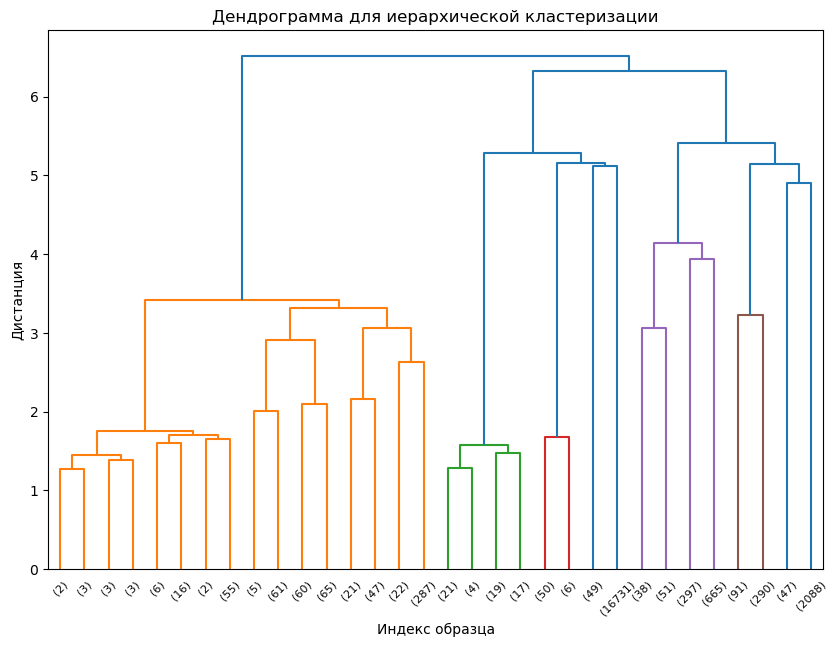

In [19]:
linkage_matrix = linkage(svd_matrix_normalized, method='ward', metric='euclidean')

# Визуализация дендрограммы
plt.figure(figsize=(10, 7))
plt.title("Дендрограмма для иерархической кластеризации")
dendrogram(linkage_matrix, truncate_mode='level', p=4) 
plt.xlabel("Индекс образца")
plt.ylabel("Дистанция")
plt.show()

На основе дендрограммы я пришел к тому, что 16 кластеров - наиболее подходящий вариант. При установке параметра p=3 в dendrogram, он выдаст как раз 16.

In [20]:
start_time = time.time()
clustering = AgglomerativeClustering(n_clusters=16, metric='euclidean', linkage='ward')
clustering.fit(svd_matrix_normalized)

print(f"Время выполнения: {time.time() - start_time} секунд")

Время выполнения: 326.3206706047058 секунд


In [21]:
gc.collect()

5657

In [22]:
df_clusters = pd.DataFrame({
    'Очищенное описание': all_films['Очищенное описание'],
    'Кластер иерархической кластеризации': clustering.labels_
})

In [23]:
df_clusters

,Очищенное описание,Кластер иерархической кластеризации
0,фильм погружать зритель повседневный великий и...,4
1,сериал основать бестселлер рафаэль бакка кайзе...,5
2,решительный социальный работник посвятить помо...,4
3,история кассандро начинаться эль пасо молодой ...,4
4,скромный непубличный джентльмен николас уинтон...,4
...,...,...
21117,далёкий волшебный легенда оживать сказка стано...,4
21118,сонм небесный светить ангел оберегать чистота ...,5
21119,тихий уголок течь черёд существовать невидимый...,6
21120,ноэль занимать должность менеджер персонал огр...,12


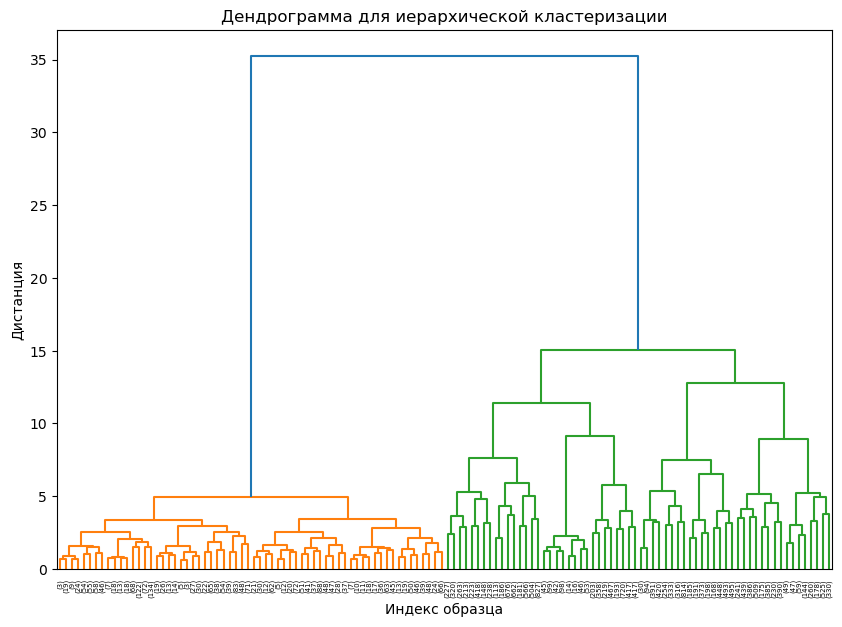

In [24]:
linkage_matrix = linkage(svd_embeddings_normalized, method='ward', metric='euclidean')

# Визуализация дендрограммы
plt.figure(figsize=(10, 7))
plt.title("Дендрограмма для иерархической кластеризации")
dendrogram(linkage_matrix, truncate_mode='level', p=6) 
plt.xlabel("Индекс образца")
plt.ylabel("Дистанция")
plt.show()

Дендрограмма для иерархической кластеризацией с векторизатором BERT так же выдаляет 16 кластеров

In [25]:
start_time = time.time()
clustering_bert_agg = AgglomerativeClustering(n_clusters=16, metric='euclidean', linkage='ward')
clustering_bert_agg.fit(svd_embeddings_normalized)

print(f"Время выполнения: {time.time() - start_time} секунд")

Время выполнения: 24.27088952064514 секунд


In [26]:
df_clusters['Кластер Иерархической кластеризации BERT'] = clustering_bert_agg.labels_

In [27]:
df_clusters

,Очищенное описание,Кластер иерархической кластеризации,Кластер Иерархической кластеризации BERT
0,фильм погружать зритель повседневный великий и...,4,12
1,сериал основать бестселлер рафаэль бакка кайзе...,5,2
2,решительный социальный работник посвятить помо...,4,8
3,история кассандро начинаться эль пасо молодой ...,4,2
4,скромный непубличный джентльмен николас уинтон...,4,14
...,...,...,...
21117,далёкий волшебный легенда оживать сказка стано...,4,1
21118,сонм небесный светить ангел оберегать чистота ...,5,1
21119,тихий уголок течь черёд существовать невидимый...,6,10
21120,ноэль занимать должность менеджер персонал огр...,12,1


Кластеризация с помощью DBSCAN:

In [137]:
start_time = time.time()
cluster_model = DBSCAN(eps=0.8,min_samples=20, metric='cosine')

clusters = cluster_model.fit_predict(svd_matrix_normalized)
print(f"Время выполнения: {time.time() - start_time} секунд")

Время выполнения: 19.29399013519287 секунд


In [138]:
df_clusters['Кластер DBSCAN'] = clusters

In [139]:
df_clusters['Кластер DBSCAN'].unique()

array([ 0, -1,  2,  1,  3], dtype=int64)

In [140]:
df_clusters

,Очищенное описание,Кластер иерархической кластеризации,Кластер Иерархической кластеризации BERT,Кластер DBSCAN,Кластер SpectralClustering tf-idf,Кластер SpectralClustering BERT,Кластер LDA,Кластер K-means tf-idf,Кластер K-means BERT
0,фильм погружать зритель повседневный великий и...,4,12,0,15,15,0,4,8
1,сериал основать бестселлер рафаэль бакка кайзе...,5,2,0,6,6,0,4,8
2,решительный социальный работник посвятить помо...,4,8,0,6,6,1,13,7
3,история кассандро начинаться эль пасо молодой ...,4,2,-1,6,6,1,4,12
4,скромный непубличный джентльмен николас уинтон...,4,14,0,3,3,0,7,8
...,...,...,...,...,...,...,...,...,...
21117,далёкий волшебный легенда оживать сказка стано...,4,1,0,9,9,2,6,15
21118,сонм небесный светить ангел оберегать чистота ...,5,1,0,14,14,13,3,15
21119,тихий уголок течь черёд существовать невидимый...,6,10,-1,12,12,2,6,10
21120,ноэль занимать должность менеджер персонал огр...,12,1,-1,14,14,13,15,15


DBSCAN при длительном подборе параметров не дал адекватных результатов.

In [256]:
del embeddings

In [59]:
gc.collect()

13242

Кластеризация с помощью SpectralClustering:

In [60]:
start_time = time.time()
similarity_matrix = 1 - pairwise_distances(tfidf_matrix, metric='cosine')

# Применение спектральной кластеризации
spectral = SpectralClustering(n_clusters=16, affinity='precomputed', random_state=29)
spectral_labels = spectral.fit_predict(similarity_matrix)
print(f"Время выполнения: {time.time() - start_time} секунд")

D:\Anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Время выполнения: 957.6328854560852 секунд


In [61]:
gc.collect()

0

In [62]:
df_clusters['Кластер SpectralClustering tf-idf'] = spectral_labels

In [63]:
start_time = time.time()
similarity_matrix_bert = 1 - pairwise_distances(svd_embeddings_normalized, metric='cosine')

# Применение спектральной кластеризации
spectral_bert = SpectralClustering(n_clusters=16, affinity='precomputed', random_state=29)
spectral_bert_labels = spectral_bert.fit_predict(similarity_matrix_bert)
print(f"Время выполнения: {time.time() - start_time} секунд")

Время выполнения: 908.6430084705353 секунд


In [64]:
df_clusters['Кластер SpectralClustering BERT'] = spectral_labels

In [141]:
gc.collect()

0

LDA кластеризация:

In [66]:
start_time = time.time()
# Векторизация текстов (CountVectorizer)
count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(all_films['Очищенное описание'])

# Применение LDA
lda = LatentDirichletAllocation(n_components=16, random_state=29)
lda.fit(X_counts)

df_clusters['Кластер LDA'] = lda.transform(X_counts).argmax(axis=1)
print(f"Время выполнения: {time.time() - start_time} секунд")

Время выполнения: 75.33796167373657 секунд


In [67]:
# Вывод тем и топ-слов для каждой темы
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Тема {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

n_top_words = 8
cv_feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda, cv_feature_names, n_top_words)

Тема 1:
фильм история зритель захватывать герой сюжет уникальный персонаж
Тема 2:
становиться испытание история мечта команда трудность начинать несмотря
Тема 3:
история путешествие любовь сердце приключение судьба становиться испытание
Тема 4:
девушка ребёнок собственный пытаться молодой героиня дочь сестра
Тема 5:
мужчина парень деньга девушка смочь преступник прийтись вскоре
Тема 6:
иван дэнни ник царь дракон бобби тед эллен
Тема 7:
герой парень героиня смочь готовый сильно приключение девушка
Тема 8:
начинать становиться джек способность оказываться реальность сталкиваться возможность
Тема 9:
миссия команда опасный агент задание цель угроза операция
Тема 10:
история борьба враг власть справедливость становиться герой испытание
Тема 11:
любовь девушка семья настоящий начинать ребёнок молодой приключение
Тема 12:
начинать расследование становиться семья преступление убийство тайна сын
Тема 13:
ребёнок смочь сын молодой несмотря настоящий трудность люк
Тема 14:
становиться отношение и

In [68]:
df_clusters

,Очищенное описание,Кластер иерархической кластеризации,Кластер Иерархической кластеризации BERT,Кластер DBSCAN,Кластер SpectralClustering tf-idf,Кластер SpectralClustering BERT,Кластер LDA
0,фильм погружать зритель повседневный великий и...,4,12,0,15,15,0
1,сериал основать бестселлер рафаэль бакка кайзе...,5,2,0,6,6,0
2,решительный социальный работник посвятить помо...,4,8,0,6,6,1
3,история кассандро начинаться эль пасо молодой ...,4,2,0,6,6,1
4,скромный непубличный джентльмен николас уинтон...,4,14,0,3,3,0
...,...,...,...,...,...,...,...
21117,далёкий волшебный легенда оживать сказка стано...,4,1,0,9,9,2
21118,сонм небесный светить ангел оберегать чистота ...,5,1,0,14,14,13
21119,тихий уголок течь черёд существовать невидимый...,6,10,0,12,12,2
21120,ноэль занимать должность менеджер персонал огр...,12,1,0,14,14,13


Для кластеризации K-means построим графики-локтя, на основе которого можно определить количество кластеров, если график примет локтевидную форму

In [69]:
def generate_elbow_plot(matrix):
    k_values = range(1, 25)
    inertia_values = [MiniBatchKMeans(k, batch_size=1536).fit(matrix).inertia_ for k in k_values]
    plt.plot(k_values, inertia_values)
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

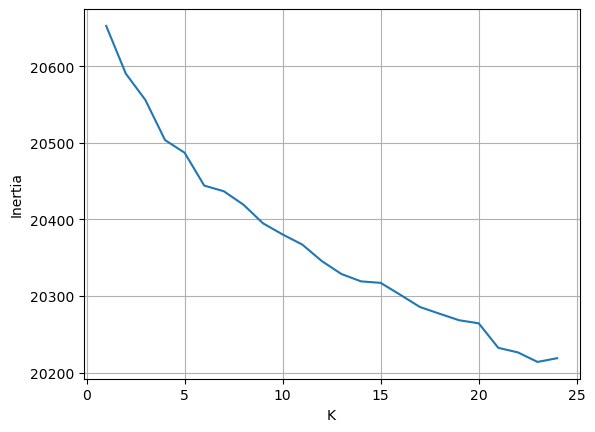

Время выполнения: 54.237945556640625 секунд


In [70]:
start_time = time.time()
generate_elbow_plot(svd_matrix_normalized)
print(f"Время выполнения: {time.time() - start_time} секунд")

На графике отсутствует что-то локтевидное, поэтому просто возьмем количество кластеров, подобранное из предыдущих методов

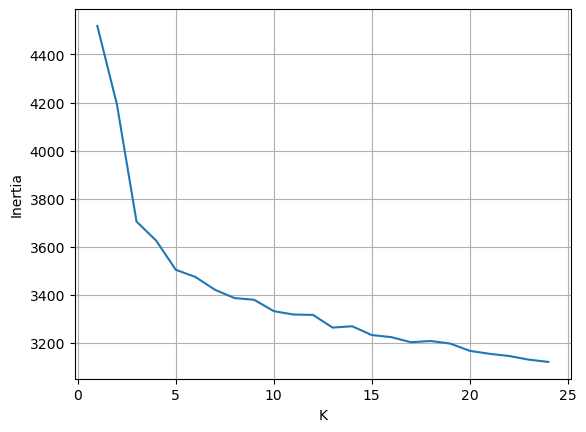

Время выполнения: 2.105560064315796 секунд


In [71]:
start_time = time.time()
generate_elbow_plot(svd_embeddings_normalized)
print(f"Время выполнения: {time.time() - start_time} секунд")

Для BERT-векторизатора график содержит что-то похожее на локоть, но он предполагает количество кластеров в районе 3-5, что мало для наших данных, поэтому так же будем использовать 16 кластеров как и в предыдущих методах

In [72]:
gc.collect()

3157

In [73]:
model = KMeans(n_clusters=16)
clusters = model.fit_predict(svd_matrix_normalized)

In [74]:
df_clusters['Кластер K-means tf-idf'] = clusters

In [75]:
model = KMeans(n_clusters=16)
clusters_bert = model.fit_predict(svd_embeddings_normalized)

In [76]:
df_clusters['Кластер K-means BERT'] = clusters_bert

In [77]:
df_clusters

,Очищенное описание,Кластер иерархической кластеризации,Кластер Иерархической кластеризации BERT,Кластер DBSCAN,Кластер SpectralClustering tf-idf,Кластер SpectralClustering BERT,Кластер LDA,Кластер K-means tf-idf,Кластер K-means BERT
0,фильм погружать зритель повседневный великий и...,4,12,0,15,15,0,4,8
1,сериал основать бестселлер рафаэль бакка кайзе...,5,2,0,6,6,0,4,8
2,решительный социальный работник посвятить помо...,4,8,0,6,6,1,13,7
3,история кассандро начинаться эль пасо молодой ...,4,2,0,6,6,1,4,12
4,скромный непубличный джентльмен николас уинтон...,4,14,0,3,3,0,7,8
...,...,...,...,...,...,...,...,...,...
21117,далёкий волшебный легенда оживать сказка стано...,4,1,0,9,9,2,6,15
21118,сонм небесный светить ангел оберегать чистота ...,5,1,0,14,14,13,3,15
21119,тихий уголок течь черёд существовать невидимый...,6,10,0,12,12,2,6,10
21120,ноэль занимать должность менеджер персонал огр...,12,1,0,14,14,13,15,15


Рассмотрим метрики для каждой кластеризации:

In [79]:
for column in ['Кластер иерархической кластеризации', 'Кластер DBSCAN', "Кластер SpectralClustering tf-idf", "Кластер K-means tf-idf"]:
    labels = df_clusters[column]
    # Используем текстовые вектора для вычисления метрик
    silhouette_avg = silhouette_score(svd_matrix_normalized, labels)
    calinski_harabasz_avg = calinski_harabasz_score(svd_matrix_normalized, labels)
    davies_bouldin_avg = davies_bouldin_score(svd_matrix_normalized, labels)
    
    print(f"Метрики для {column}:")
    print(f"Силуэтный коэффициент: {silhouette_avg}")
    print(f"Коэффициент Калинского-Харабаса: {calinski_harabasz_avg}")
    print(f"Индекс Дэвиса-Болдина: {davies_bouldin_avg}")
    print("-" * 30)

Метрики для Кластер иерархической кластеризации:
Силуэтный коэффициент: -0.002517000245450796
Коэффициент Калинского-Харабаса: 13.910136995632593
Индекс Дэвиса-Болдина: 12.040961519582979
------------------------------
Метрики для Кластер DBSCAN:
Силуэтный коэффициент: -0.2846291432850184
Коэффициент Калинского-Харабаса: 0.9427944451786349
Индекс Дэвиса-Болдина: 10.400910865215701
------------------------------
Метрики для Кластер SpectralClustering tf-idf:
Силуэтный коэффициент: 0.003533278918961083
Коэффициент Калинского-Харабаса: 24.655656259653064
Индекс Дэвиса-Болдина: 12.630091747231827
------------------------------
Метрики для Кластер K-means tf-idf:
Силуэтный коэффициент: 0.0031082591796343442
Коэффициент Калинского-Харабаса: 26.66698399568776
Индекс Дэвиса-Болдина: 12.064465758695153
------------------------------


In [80]:
for column in ['Кластер Иерархической кластеризации BERT','Кластер SpectralClustering BERT',"Кластер K-means BERT"]:
    labels = df_clusters[column]
    # Используем текстовые вектора для вычисления метрик
    silhouette_avg = silhouette_score(svd_embeddings_normalized, labels)
    calinski_harabasz_avg = calinski_harabasz_score(svd_embeddings_normalized, labels)
    davies_bouldin_avg = davies_bouldin_score(svd_embeddings_normalized, labels)
    
    print(f"Метрики для {column}:")
    print(f"Силуэтный коэффициент: {silhouette_avg}")
    print(f"Коэффициент Калинского-Харабаса: {calinski_harabasz_avg}")
    print(f"Индекс Дэвиса-Болдина: {davies_bouldin_avg}")
    print("-" * 30)

Метрики для Кластер Иерархической кластеризации BERT:
Силуэтный коэффициент: 0.024420373141765594
Коэффициент Калинского-Харабаса: 470.03410269753624
Индекс Дэвиса-Болдина: 4.688561555709675
------------------------------
Метрики для Кластер SpectralClustering BERT:
Силуэтный коэффициент: -0.007168218027800322
Коэффициент Калинского-Харабаса: 149.43839988718463
Индекс Дэвиса-Болдина: 5.653277784173337
------------------------------
Метрики для Кластер K-means BERT:
Силуэтный коэффициент: 0.025319010019302368
Коэффициент Калинского-Харабаса: 589.582281850642
Индекс Дэвиса-Болдина: 3.6180443305692163
------------------------------


Лучший вариант по данным метрикам - k-means с BERT векторизатором.

Теперь посмотрим что получилось лучше на облаках слов

In [158]:
n_clusters = 16
cluster_names = df_clusters['Кластер K-means tf-idf']
terms = tfidf_vectorizer.get_feature_names_out()
cluster_tfidf = {i: [] for i in range(n_clusters)}

# Заполнение словаря TF-IDF весами для каждого кластера
for i in range(n_clusters):
    cluster_indices = np.where(cluster_names == i)[0]
    cluster_matrix = tfidf_matrix[cluster_indices].mean(axis=0)
    cluster_tfidf[i] = np.array(cluster_matrix).flatten()


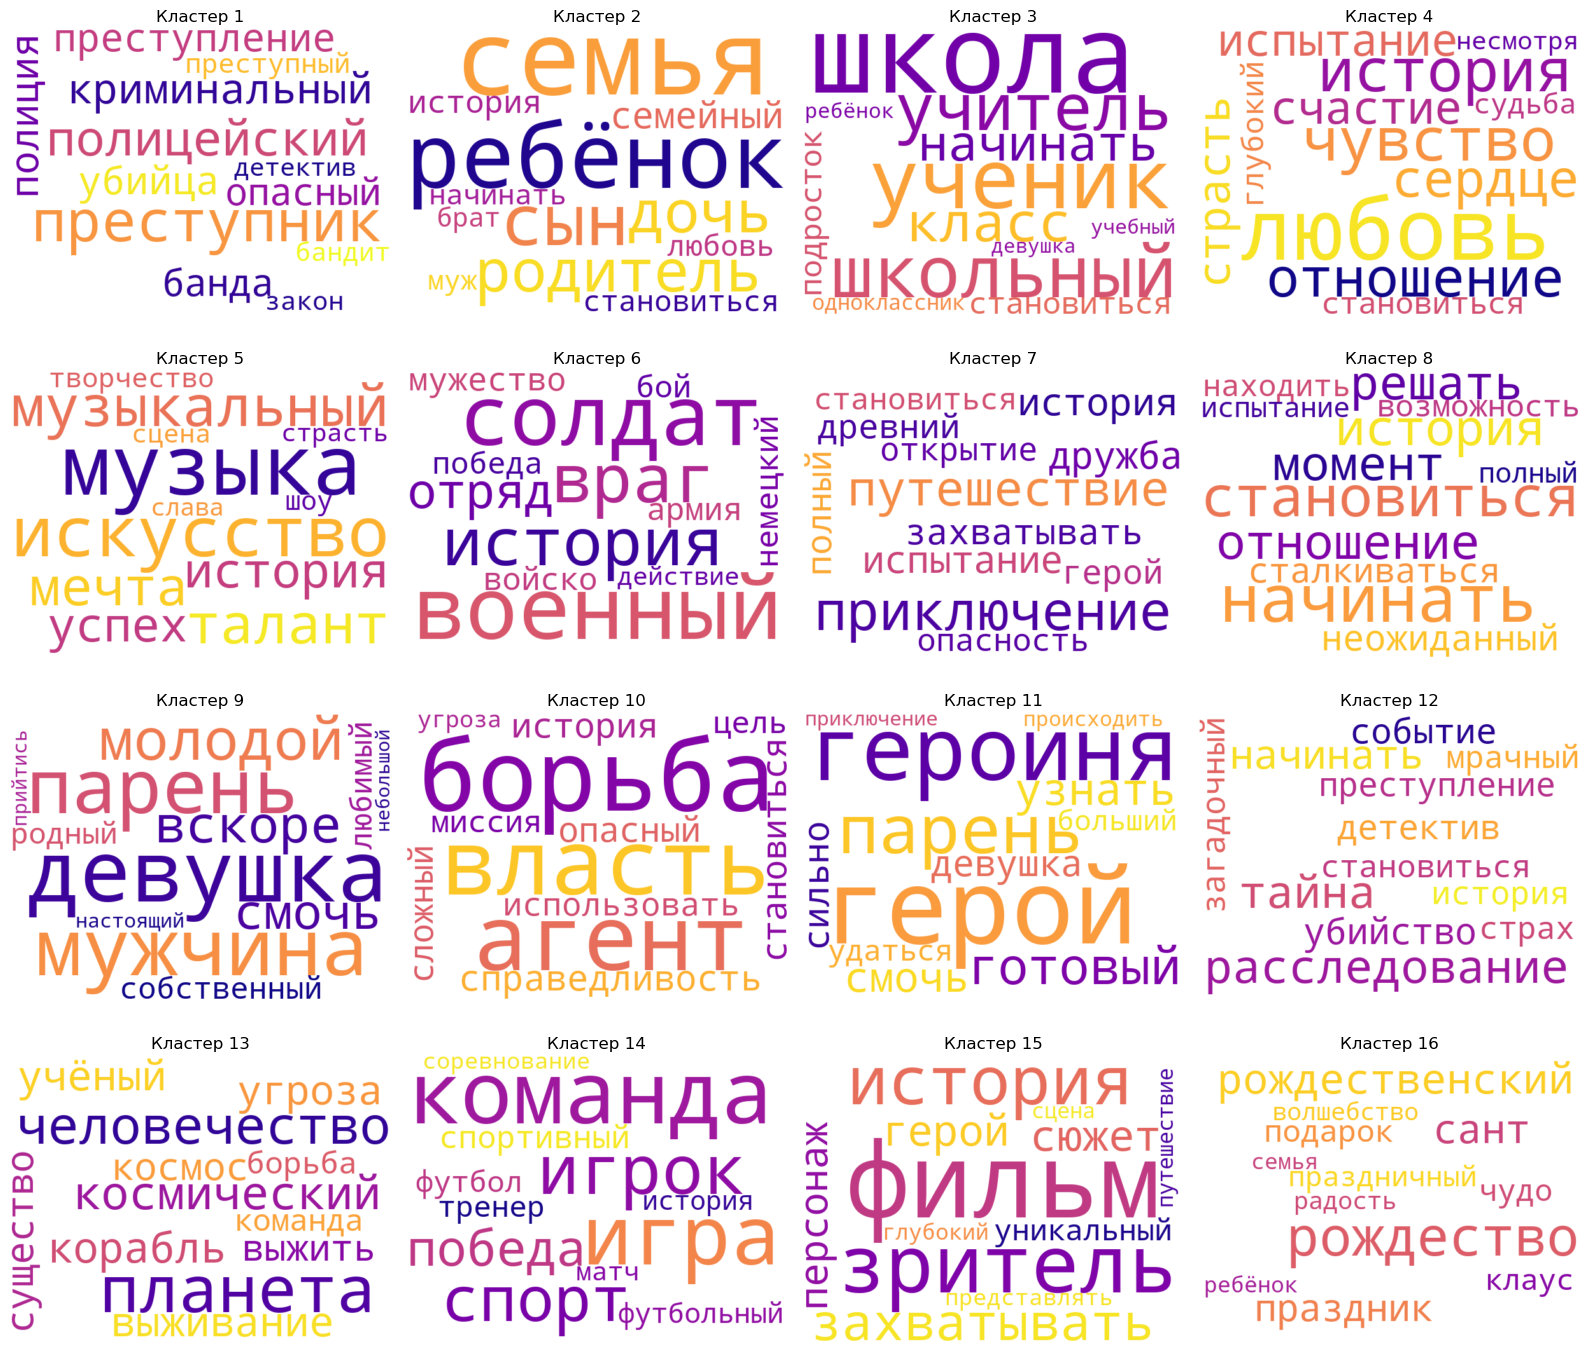

In [159]:
wordclouds = []
for i in range(n_clusters):
    # Создание словаря {слово: tf-idf значение} для WordCloud
    word_weights = {terms[j]: cluster_tfidf[i][j] for j in range(len(terms))}
    wordcloud = WordCloud(width=600, height=450, background_color='white', colormap=plt.get_cmap('plasma'), max_words=12).generate_from_frequencies(word_weights)
    wordclouds.append(wordcloud)

fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.flatten()



    
for i in range(16):
    if i < n_clusters:
        axes[i].imshow(wordclouds[i], interpolation='bilinear')
        axes[i].set_title(f'Кластер {i+1}')
    else:
        axes[i].axis('off')  # Выключаем оси для лишних ячеек
    axes[i].axis('off')


plt.tight_layout()
plt.show()

Такие облака слов дают понимание намного лучше, чем метрики, которые мы применяли выше.

На основе этих облаков слов я так оценил различные методы кластеризации:

LDA оценил на 2 балла, иерархическую кластеризацию с tf-idf векторизатором на 4 балла, кластеризацию K-means с tf-idf векторизатором на 8 баллов, DBSCAN на 0 баллов, иерархическую кластеризацию с BERT векторизатором на 3 балла, кластеризацию SpectralClustering с BERT векторизатором на 6 баллов, кластеризацию SpectralClustering с tf-idf векторизатором на 4 балла, кластеризацию K-means с BERT векторизатором на 2 балла

Таким образом, лучшей кластеризацией в нашем случае получилась K-means с tf-idf векторизатором

In [109]:
merged_df = pd.concat([df_clusters, all_films[['Жанры', "Описание"]]], axis=1)

Выведем жанры и соответствующие им описания для определенного кластера:

In [110]:

def print_cluster_sample(cluster_id=0, clust_name='Кластер K-means tf-idf'):
    df_cluster = merged_df[merged_df[clust_name]==cluster_id]
    np.random.seed(29)
    for genre, text in zip(np.random.choice(df_cluster['Жанры'].values, 5, replace=False),np.random.choice(df_cluster.Описание.values, 5, replace=False)):
        print('\n', genre, ':\n\n', text)

In [111]:
print_cluster_sample()


 Боевик,Драма,Криминал,Приключения,Триллер :

 Главный герой фильма – Джон Чепмен, известный под прозвищем "Сокол", является бывшим членом морской пехоты. Он решил уйти от службы после многих лет, но с возрастом ему стало трудно адаптироваться к обычной жизни. Более того, он страдает необычным недугом: нервным расстройством, вызванным длительным нахождением в боевых условиях. Теперь Джон не может чувствовать себя спокойно, если не занимается насилием, иначе он начнет причинять вред себе. Диагноз звучит ужасающе, и герою приходится тяжело справляться с этой проблемой.Однако его жизнь меняется в одно мгновение, когда его единственную родственную душу - сестру - жестоко убивают в Сан-Паулу. Горе и боль охватывают Джона, но в этот трудный момент в его жизни появляется мощный стимул - месть за смерть сестры. Без колебаний он отправляется в Бразилию на поиски убийцы. Однако на его пути встают не только преступники, но и опасная наркобанда, занимающаяся подпольной торговлей. Планы Джона оказ

## Как видим данный кластер содержит в себе описания о фильмах, где сюжет связан с криминалом

In [113]:
print_cluster_sample(2)


 Детектив,Драма,Триллер :

 Увлекательный, веселый и полезный мультсериал «Волшебный школьный автобус снова возвращается» повествует о приключениях учительницы мисс Фреззл и ее любимых учениках.Самая любимая учительница из небольшой американской школы снова путешествует по городу на волшебном школьном автобусе вместе с талантливыми, изобретательными и послушными учениками. Она намерена показать всем горожанам те свои научные достижения, которые ей удалось достичь за долгие часы утомительного и кропотливого труда. Также мисс Фреззл желает научить всех детей полезным урокам этикета, чтобы они хорошо себя вели в жизни, и не разочаровывали своих родителей и друзей. Поэтому каждое новое путешествие учительницы – это еще одно приключение и для нее, и для всех тех детишек, которые располагаются на мягких сидениях магического транспортного средства. Так что путешествовать с учительницей – это одно сплошное удовольствие, которое приносит пользу всем тем школьникам, которые мечтают добиться чег

## Данный кластер содержит в себе описания о фильмах, связанных со школой

Следующим этапом может быть применение полученной кластеризации как признака в предсказании жанров